## Evoluční generování 1D terénu pomocí knihovny DEAP
Evoluční algoritmus pro generování 1D modelu terénu (výškového profilu) s vrcholy a jezery (zatopenými oblastmi). S využitím knihovny DEAP pro optimalizaci profilu podle stanovených kritérií. Výstup tvoří tabulka analýzy hodnot v průběhu evoluce. Dále hodnoty nejlepšího výsledku včetně zobrazení výškového profilu, graf vývoje hodnoty fitness funkce a také grafické porovnání pěti nejlepších výsledků.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms

Terén je reprezentován jako jednodimenzionální posloupnost sta bodů o výšce 0–1, s vodní hladinou v hodnotě 0.5. Evoluce je nastavená na 50 generací. 

In [93]:
# Nastavení parametrů
TERRAIN_POINTS = 100  # Počet bodů terénu na ose x
WATER_LEVEL = 0.5     # Výška vodní hladiny
POP_SIZE = 100        # Velikost populace
NGEN = 50             # Počet generací
CXPB = 0.7            # Pravděpodobnost křížení
MUTPB = 0.2           # Pravděpodobnost mutace
TOURNSIZE = 3         # Velikost turnaje pro selekci

Vrchol je definován jako bod, který je vyšší než oba jeho sousedé. Jezero jako spojitá oblast pod vodní hladinou. Tři z celkem šesti kritérií (viz níže) mají navýšené váhy.

In [94]:
# Maximalizace fitness (6 kritérií)
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.2, 1.0, 1.5, 1.2, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Generování náhodných hodnot výšky v rozmezí 0-1
toolbox.register("attr_height", random.random)

# Inicializace jednotlivce a populace
toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.attr_height, n=TERRAIN_POINTS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def count_peaks_and_lakes(terrain):
    """
    Spočítá počet vrcholů a jezer v terénu.
    """
    peaks = 0
    lakes = 0
    is_lake = False
    
    # Detekce vrcholů
    for i in range(1, len(terrain) - 1):
        if terrain[i] > terrain[i-1] and terrain[i] > terrain[i+1]:
            peaks += 1
    
    # Detekce jezer
    for i in range(len(terrain)):
        if terrain[i] < WATER_LEVEL:
            if not is_lake:
                lakes += 1
                is_lake = True
        else:
            is_lake = False
    
    return peaks, lakes

def calculate_lake_sizes(terrain):
    """
    Vypočítá velikosti jednotlivých jezer jako šířku (počet bodů) na úrovni vodní hladiny.
    """
    lake_sizes = []
    current_lake_size = 0
    is_lake = False
    
    for height in terrain:
        if height < WATER_LEVEL:
            current_lake_size += 1
            is_lake = True
        elif is_lake:
            lake_sizes.append(current_lake_size)
            current_lake_size = 0
            is_lake = False
    
    # Přidání posledního jezera, pokud končí na konci terénu
    if is_lake:
        lake_sizes.append(current_lake_size)
    
    return lake_sizes

def find_peaks_and_valleys(terrain):
    """
    Najde vrcholy a údolí v terénu a vrátí jejich indexy a velikosti.
    """
    peaks = []
    valleys = []
    
    for i in range(1, len(terrain) - 1):
        if terrain[i] > terrain[i-1] and terrain[i] > terrain[i+1]:
            # Vrchol - spočítáme jeho šířku/bázi
            left_idx = i
            right_idx = i
            
            # Pohyb doleva dokud klesá
            while left_idx > 0 and terrain[left_idx-1] < terrain[left_idx]:
                left_idx -= 1
                
            # Pohyb doprava dokud klesá
            while right_idx < len(terrain) - 1 and terrain[right_idx+1] < terrain[right_idx]:
                right_idx += 1
                
            width = right_idx - left_idx
            height = terrain[i]
            peaks.append((i, height, width))
            
        elif terrain[i] < terrain[i-1] and terrain[i] < terrain[i+1]:
            # Údolí - spočítáme jeho šířku/bázi
            left_idx = i
            right_idx = i
            
            # Pohyb doleva dokud stoupá
            while left_idx > 0 and terrain[left_idx-1] > terrain[left_idx]:
                left_idx -= 1
                
            # Pohyb doprava dokud stoupá
            while right_idx < len(terrain) - 1 and terrain[right_idx+1] > terrain[right_idx]:
                right_idx += 1
                
            width = right_idx - left_idx
            depth = 1 - terrain[i]  # Hloubka údolí
            valleys.append((i, depth, width))
            
    return peaks, valleys


Funkce fitness se šesti kritérii: celkový počet vrcholů a jezer, variabilita výšky terénu (preference vyšší rozmanitosti), procento zatopených oblastí (optimálně 20-40 %), míra špičatosti vrcholů (preference větší šířky), výška terénu (preference vyšších hodnot a rozmanitosti), velikost jezer (šířka hladiny).

In [95]:
def evaluate(individual):
    """
    Fitness funkce pro hodnocení kvality terénu.
    """
    # Výška vždy v rozmezí 0-1
    terrain = [max(0, min(1, h)) for h in individual]
    
    # Základní počet vrcholů a jezer
    peaks, lakes = count_peaks_and_lakes(terrain)
    
    # Kritérium 1: Počet vrcholů a jezer s preferencí pro počet 5-10 vrcholů a 3-5 jezer (jaký vliv?)
    peak_lake_score = min(peaks, 10) / 10 + min(lakes, 5) / 5  
    
    # Kritérium 2: Variabilita krajiny - měřená pomocí směrodatné odchylky výšek
    variability = np.std(terrain)
    variability_score = min(variability * 2, 1.0)  # Preference vyšší variability
    
    # Kritérium 3: Procento zatopených oblastí
    flooded_area = sum(1 for h in terrain if h < WATER_LEVEL) / len(terrain)
    # Preference 20-40 % zatopení (?)
    if 0.2 <= flooded_area <= 0.4:
        flooded_score = 1.0
    else:
        flooded_score = 1.0 - min(abs(flooded_area - 0.3) * 3, 1.0)
    
    # Kritérium 4: Šířka vrcholů
    peaks_info, valleys_info = find_peaks_and_valleys(terrain)
    
    # Preference širších vrcholů
    avg_peak_width = np.mean([width for _, _, width in peaks_info]) if peaks_info else 0
    peak_width_score = min(avg_peak_width / 15, 1.0)  # Preferujeme ještě širší vrcholy
    
    # Kritérium 5: Vylepšená rozmanitost výšek vrcholů (namísto max výšky)
    terrain_array = np.array(terrain)
    average_height = np.mean(terrain_array)
    height_variability = np.std(terrain_array)

    # Preference průměru kolem 0.6 a zároveň vysoké rozmanitosti
    height_score = ((1 - abs(average_height - 0.6)) * 0.7 + (height_variability * 0.3))
    max_height_score = min(height_score, 1.0)  # Normalizace skóre

    # Kritérium 6: Velikost jezer - šířka hladiny jezera
    lake_sizes = calculate_lake_sizes(terrain)
    if lake_sizes:
        avg_lake_size = sum(lake_sizes) / len(lake_sizes)
        lake_size_score = min(avg_lake_size / 15, 1.0)  # Preference větších jezer
    else:
        lake_size_score = 0.0
    
    return peak_lake_score, variability_score, flooded_score, peak_width_score, max_height_score, lake_size_score

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)

# Upravená mutace pro zajištění hodnot v rozmezí 0-1
def mutate_bounded(individual, mu, sigma, indpb):
    """
    Mutace s omezením na hodnoty v rozmezí 0-1.
    """
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] += random.gauss(mu, sigma)
            individual[i] = max(0, min(1, individual[i]))  # Omezení na rozsah 0-1
    return individual,

toolbox.register("mutate", mutate_bounded, mu=0, sigma=0.15, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)

def run_evolution():
    """
    Spustí evoluční algoritmus pro generování terénu.
    """
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, 
                                 stats=stats, halloffame=hof, verbose=True)
    
    return pop, log, hof

Funkce pro výpis a vykreslení výstupů:

In [96]:
def plot_terrain(terrain, title="Vygenerovaný terén"):
    """
    Vykreslí terén s vodní hladinou.
    """
    plt.figure(figsize=(12, 6))
    
    # Vykreslení terénu
    x = np.linspace(0, 1, len(terrain))
    plt.plot(x, terrain, 'brown', linewidth=2, label='Terén')
    
    # Vykreslení vodní hladiny
    plt.axhline(y=WATER_LEVEL, color='b', linestyle='-', alpha=0.7, label='Vodní hladina')
    
    # Vybarvení oblasti, kde je voda (hladina vyšší než terén)
    plt.fill_between(x, terrain, WATER_LEVEL, where=[h < WATER_LEVEL for h in terrain], 
                     color='blue', alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Pozice')
    plt.ylabel('Výška')
    plt.ylim(0, 1.1)  # Zvýšení horní hranice pro lepší zobrazení
    plt.grid(True)
    plt.legend()
    
    # Výpočet a zobrazení statistik
    peaks, lakes = count_peaks_and_lakes(terrain)
    lake_sizes = calculate_lake_sizes(terrain)
    flooded_area = sum(1 for h in terrain if h < WATER_LEVEL) / len(terrain) * 100
    
    # Získání informací o vrcholech a údolích pro zobrazení šířky
    peaks_info, valleys_info = find_peaks_and_valleys(terrain)
    avg_peak_width = np.mean([width for _, _, width in peaks_info]) if peaks_info else 0
    avg_height = np.mean(terrain)
    
    stats_text = f'Počet vrcholů: {peaks}\n'
    stats_text += f'Průměrná výška: {avg_height:.2f}\n'
    stats_text += f'Průměrná šířka vrcholů: {avg_peak_width:.1f} bodů\n'
    stats_text += f'Počet jezer: {lakes}\n'
    stats_text += f'Zatopená oblast: {flooded_area:.1f}%\n'
    
    if lake_sizes:
        stats_text += f'Průměrná velikost jezera: {sum(lake_sizes)/len(lake_sizes):.1f} bodů\n'
        stats_text += f'Velikosti jezer: {lake_sizes}'
    
    plt.figtext(0.02, 0.02, stats_text, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    return plt.gcf()

def analyze_best_individual(hof):
    """
    Analyzuje a zobrazí informace o nejlepším jedinci.
    """
    best = hof[0]
    best = [max(0, min(1, h)) for h in best]  # Zajištění hodnot v rozmezí 0-1
    
    fitness_components = evaluate(best)
    
    print("Fitness komponenty nejlepšího jedince:")
    print(f"- Skóre vrcholů a jezer: {fitness_components[0]:.4f}")
    print(f"- Variabilita krajiny: {fitness_components[1]:.4f}")
    print(f"- Skóre zatopené oblasti: {fitness_components[2]:.4f}")
    print(f"- Skóre šířky vrcholů: {fitness_components[3]:.4f}")
    print(f"- Skóre výšky vrcholů: {fitness_components[4]:.4f}")
    print(f"- Skóre velikosti jezer: {fitness_components[5]:.4f}")
    print(f"- Celkové fitness: {sum(fitness_components):.4f}")
    
    peaks, lakes = count_peaks_and_lakes(best)
    print(f"\nPočet vrcholů: {peaks}")
    print(f"Počet jezer: {lakes}")
    print(f"Průměrná výška terénu: {np.mean(best):.4f}")
    
    # Informace o šířce vrcholů
    peaks_info, valleys_info = find_peaks_and_valleys(best)
    if peaks_info:
        avg_peak_width = np.mean([width for _, _, width in peaks_info])
        print(f"Průměrná šířka vrcholů: {avg_peak_width:.2f}")
    
    flooded_area = sum(1 for h in best if h < WATER_LEVEL) / len(best) * 100
    print(f"Procento zatopené oblasti: {flooded_area:.2f}%")
    
    lake_sizes = calculate_lake_sizes(best)
    if lake_sizes:
        print(f"Velikosti jednotlivých jezer: {lake_sizes}")
        print(f"Průměrná velikost jezera: {sum(lake_sizes)/len(lake_sizes):.2f}")
    
    return plot_terrain(best, title=f"Nejlepší vygenerovaný terén (Fitness: {sum(fitness_components):.4f})")

def plot_fitness_evolution(log):
    """
    Vykreslí vývoj fitness v průběhu evoluce.
    """
    gen = range(len(log.select("avg")))
    
    plt.figure(figsize=(12, 8))
    
    # Extrakce průměrné hodnoty pro každou komponentu fitness
    avg_values = np.array(log.select("avg"))
    
    # Vykreslení průměrné hodnoty pro každou komponentu
    component_names = ["vrcholy/jezera", "variabilita", "zatopení", 
                       "šířka vrcholů", "výška vrcholů", "velikost jezer"]
    for i in range(6):
        plt.plot(gen, [avg[i] for avg in avg_values], label=f"Prům. {component_names[i]}")
    
    # Vykreslení celkové průměrné fitness
    plt.plot(gen, [sum(avg) for avg in avg_values], 'k-', linewidth=2, label="Celkové fitness")
    
    plt.title("Vývoj fitness během evoluce")
    plt.xlabel("Generace")
    plt.ylabel("Hodnota fitness")
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()

Funkce Main se spuštěním evoluce a vykreslením grafů:

In [97]:
def main():
    """
    Hlavní funkce pro spuštění evolučního algoritmu a vykreslení výsledků.
    """
    # Spuštění evoluce
    pop, log, hof = run_evolution()
    
    # Analýza nejlepšího jedince
    best_last_gen = sorted(pop, key=lambda ind: sum(ind.fitness.values), reverse=True)[0]
    terrain_fig = analyze_best_individual([best_last_gen])
    
    # Vykreslení vývoje fitness
    fitness_fig = plot_fitness_evolution(log)
    
    # Porovnání několika nejlepších jedinců
    plt.figure(figsize=(12, 8))
    for i, ind in enumerate(sorted(pop, key=lambda ind: sum(ind.fitness.values), reverse=True)[:5]):
        plt.subplot(5, 1, i+1)
        x = np.linspace(0, 1, len(ind))
        # Zajistíme, že hodnoty jsou v rozmezí 0-1
        ind_bounded = [max(0, min(1, h)) for h in ind]
        plt.plot(x, ind_bounded, 'brown')
        
        # Vykreslení vodní hladiny a zatopených oblastí
        plt.axhline(y=WATER_LEVEL, color='b', linestyle='-', alpha=0.5)
        plt.fill_between(x, ind_bounded, WATER_LEVEL, where=[h < WATER_LEVEL for h in ind_bounded], 
                         color='blue', alpha=0.5)
        
        # Výpočet skóre fitness pro tento terén
        fitness = sum(evaluate(ind_bounded))
        plt.ylabel(f"Ind {i+1}\nFit: {fitness:.2f}")
        plt.ylim(0, 1.1)
        if i == 0:
            plt.title("Pět terénů s nejvyšší hodnotou funkce fitness")
        if i == 4:
            plt.xlabel("Pozice")
    
    plt.tight_layout()
    
    comparison_fig = plt.gcf()
    
    return terrain_fig, fitness_fig, comparison_fig, hof[0]

#### Výstup
- tabulková analýza hodnot v průběhu evoluce
- hodnoty nejlepšího výsledku vč. zobrazení výškového profilu
- graf vývoje hodnoty fitness funkce vč. jednotlivých položek
- vizualizované porovnání pěti nejlepších výsledků

gen	nevals	avg                                                                	std                                                                	min                                                                	max                                                                
0  	100   	[2.         0.57441676 0.3871     0.20105724 0.71690553 0.13404281]	[0.         0.02533163 0.15450757 0.01251686 0.02060622 0.01921222]	[2.         0.50605443 0.07       0.17368421 0.66777985 0.09247312]	[2.         0.63241901 1.         0.23095238 0.76156172 0.18666667]
1  	71    	[2.         0.59638385 0.4009     0.19749122 0.72277612 0.13123251]	[0.         0.02265603 0.16554211 0.01009956 0.02067035 0.02040195]	[2.         0.53038864 0.07       0.17657658 0.67831198 0.08817204]	[2.         0.64543559 1.         0.21777778 0.76568794 0.18730159]
2  	76    	[2.         0.61580348 0.4138     0.19789426 0.72759744 0.13137785]	[0.         0.01895649 0.15044454 0.01107081 0.01868322 0.01905116]	[2. 

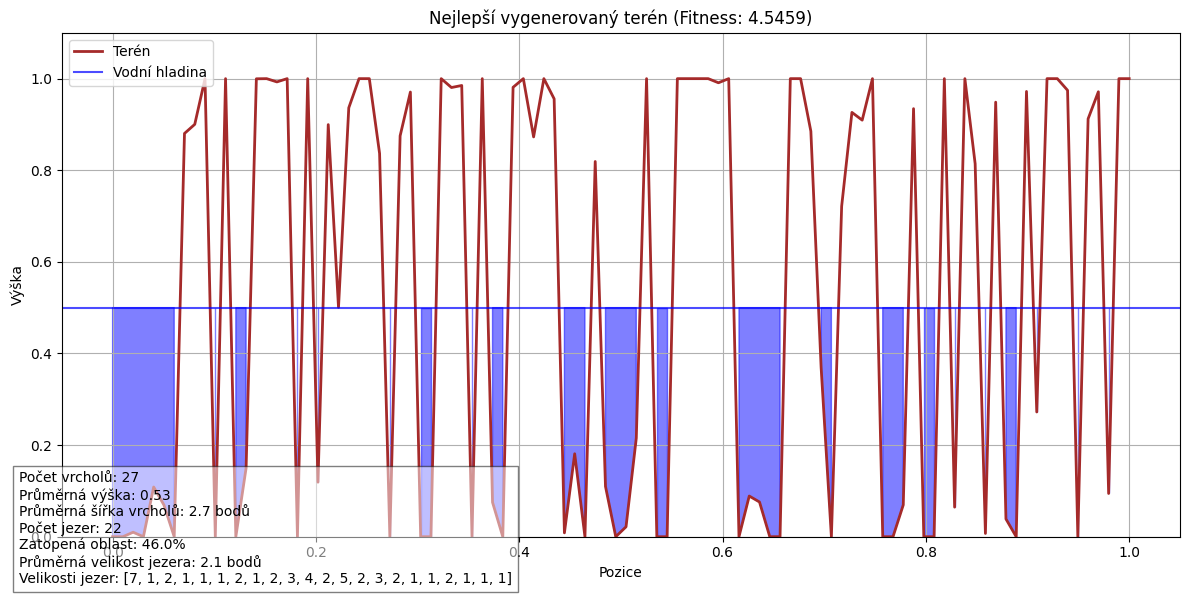

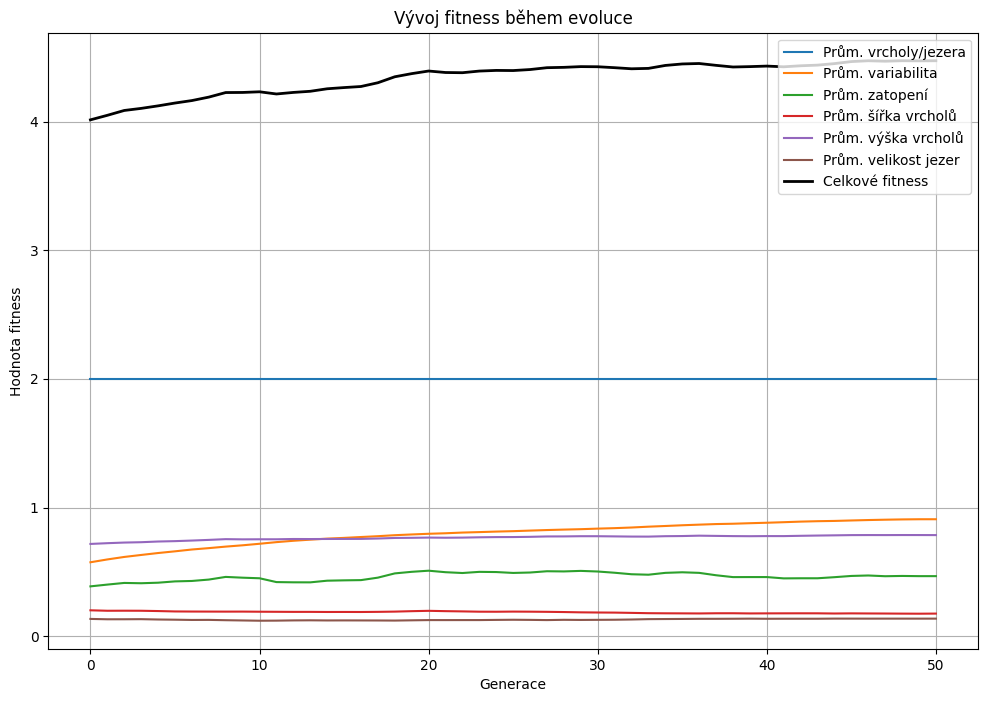

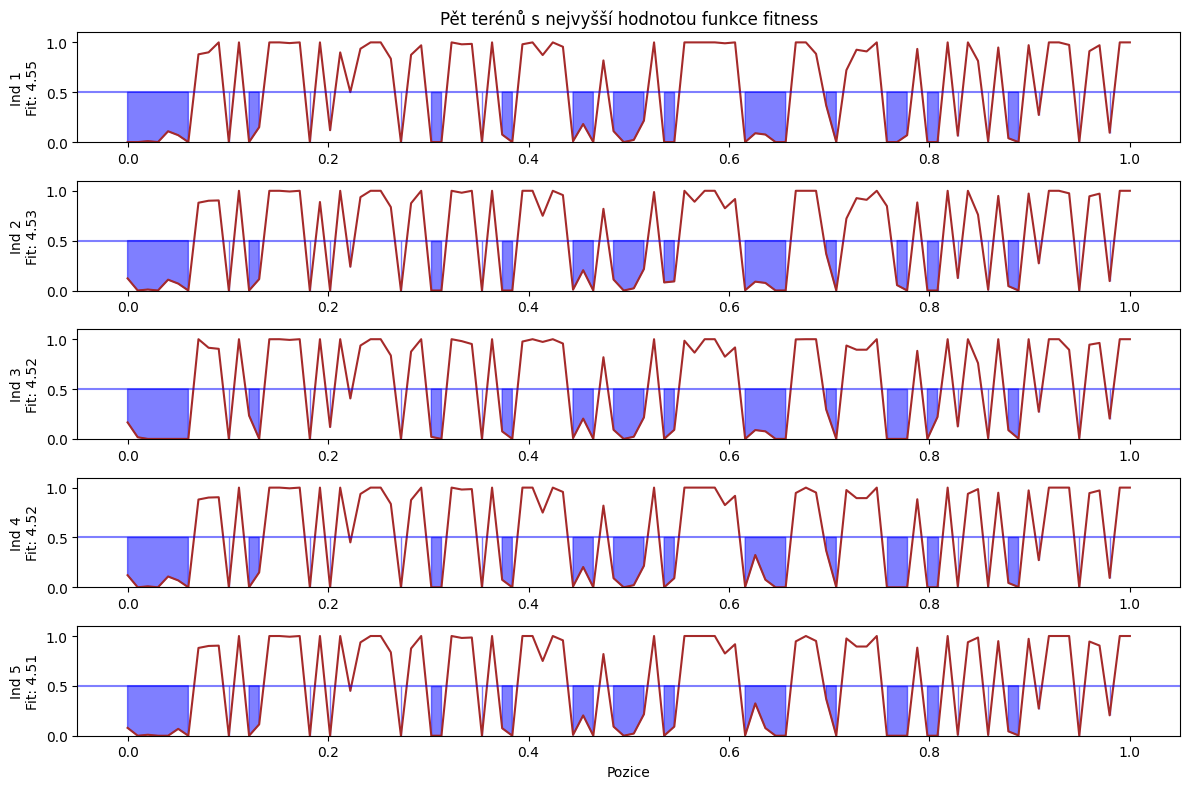

In [98]:
if __name__ == "__main__":
    terrain_fig, fitness_fig, comparison_fig, best_terrain = main()
    plt.show()